In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load Data (I have the sampled dataset ready in dataset/, so you can skip this part and the sampling part, and go directly to the Loading from CSV)

In [2]:
a1 = pyreadr.read_r(r"./dataset/TE_data/TEP_FaultFree_Training.RData")
a2 = pyreadr.read_r(r"./dataset/TE_data/TEP_Faulty_Training.RData")
a3 = pyreadr.read_r(r"./dataset/TE_data/TEP_FaultFree_Testing.RData")
a4 = pyreadr.read_r(r"./dataset/TE_data/TEP_Faulty_Testing.RData")

In [3]:
b1 = a1['fault_free_training']
b2 = a2['faulty_training']
b3 = a3['fault_free_testing']
b4 = a4['faulty_testing']

In [4]:
frames_tr = [b1,b2]
train = pd.concat(frames_tr) # Train dataframe
frames_ts = [b3,b4]
test = pd.concat(frames_ts) # Test dataframe

In [5]:
test

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,1.0,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,2705.6,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,0,1.0,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,2705.2,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,0,1.0,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,2703.5,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,0,1.0,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,2703.9,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,0,1.0,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,2707.7,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9599995,20,500.0,956,0.26494,3719.6,4536.7,9.2265,26.875,42.401,2708.3,...,54.382,26.018,62.068,20.708,37.589,35.121,45.496,42.653,40.816,15.846
9599996,20,500.0,957,0.25252,3724.0,4494.3,9.1873,27.221,41.999,2706.0,...,54.236,25.098,61.557,20.655,40.934,38.391,43.699,42.832,41.853,18.486
9599997,20,500.0,958,0.25164,3700.8,4537.3,9.2514,26.659,42.180,2704.7,...,53.722,25.185,61.169,20.650,40.694,35.961,45.643,43.147,40.538,18.127
9599998,20,500.0,959,0.29097,3641.8,4525.2,9.3053,26.823,42.234,2705.0,...,54.185,28.771,61.140,20.323,39.774,39.807,45.989,43.318,40.826,17.305


# Sampling

In [6]:
Sampled_train = pd.DataFrame() # dataframe to store the train dataset
Sampled_test = pd.DataFrame() # dataframe to store test 
Sampled_cv = pd.DataFrame() # dataframe to store cv data
# Program to construct the sample train data
frame = []
for i in set(train['faultNumber']): 
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train[train['faultNumber'] == i][0:20000]
        frame.append(b_i)
    else:
        fr = []
        b = train[train['faultNumber'] == i]
        for x in range(1,25):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
        
    frame.append(b_i)      
Sampled_train = pd.concat(frame)
# Program to construct the sample CV Data
frame = []
for i in set(train['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train[train['faultNumber'] == i][20000:30000]
        frame.append(b_i)
    else:
        fr = []
        b = train[train['faultNumber'] == i]
        for x in range(26,35):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
        
    frame.append(b_i)      
Sampled_cv = pd.concat(frame)
# Program to construct Sampled Test data
frame = []
for i in set(test['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = test[test['faultNumber'] == i][0:2000]
        frame.append(b_i)
    else:
        fr = []
        b = test[test['faultNumber'] == i]
        for x in range(1,11):
            b_x = b[b['simulationRun'] == x][160:660]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
        
    frame.append(b_i)      
Sampled_test = pd.concat(frame)

In [7]:
Sampled_train.to_csv("dataset/train.csv", index = False)
Sampled_test.to_csv("dataset/test.csv", index = False)
Sampled_cv.to_csv("dataset/cv.csv", index = False)

In [57]:
Sampled_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,20.0,24.0,496,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
239996,20.0,24.0,497,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
239997,20.0,24.0,498,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
239998,20.0,24.0,499,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


In [58]:
Sampled_cv[Sampled_cv['faultNumber'] == 11.0]

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
255020,11.0,26.0,21,0.27837,3661.2,4528.4,9.3818,26.770,41.993,2706.7,...,53.065,27.560,61.292,21.729,39.319,35.039,47.395,47.262,40.783,19.215
255021,11.0,26.0,22,0.28096,3713.5,4420.4,9.3549,27.094,42.263,2705.7,...,54.358,27.305,59.754,21.836,39.022,37.785,47.666,47.092,40.605,17.595
255022,11.0,26.0,23,0.27757,3599.6,4463.1,9.3439,26.831,42.235,2704.9,...,54.173,27.507,61.625,21.976,40.737,36.997,47.075,47.283,40.557,14.744
255023,11.0,26.0,24,0.27786,3587.9,4514.1,9.3932,26.809,42.252,2706.5,...,53.562,27.478,60.766,22.295,41.148,32.754,45.580,47.171,39.935,19.320
255024,11.0,26.0,25,0.25299,3766.0,4518.2,9.4645,27.054,42.619,2707.0,...,53.162,25.118,60.207,22.224,39.158,41.821,46.434,47.103,40.429,17.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335495,11.0,34.0,496,0.20763,3602.7,4508.3,9.3068,26.734,42.192,2700.5,...,54.659,20.294,62.611,22.026,38.577,37.302,48.327,45.024,36.719,20.479
335496,11.0,34.0,497,0.24446,3626.4,4506.5,9.3446,26.815,42.344,2703.2,...,53.167,23.961,62.008,22.139,37.800,40.334,48.930,44.971,38.582,15.989
335497,11.0,34.0,498,0.24285,3669.2,4484.4,9.2942,27.152,42.200,2704.8,...,53.431,24.120,61.055,22.397,37.806,38.989,44.923,44.665,37.514,17.759
335498,11.0,34.0,499,0.27592,3682.0,4439.7,9.3278,26.987,42.619,2702.7,...,53.967,27.310,61.812,22.075,41.452,36.516,43.860,44.615,41.475,17.325


In [59]:
Sampled_train.columns

Index(['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'],
      dtype='object')

# Loading From CSV

In [8]:
Sampled_train = pd.read_csv("dataset/train.csv")
Sampled_test = pd.read_csv("dataset/test.csv")
Sampled_cv = pd.read_csv('dataset/cv.csv')

In [9]:
Sampled_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270395,20.0,24.0,496,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
270396,20.0,24.0,497,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
270397,20.0,24.0,498,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
270398,20.0,24.0,499,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


# Training on the Whole data Set (only run this if you are gonna train on the whole dataset)

In [12]:
Sampled_train, Sampled_cv = train_test_split(train, test_size = 0.2, shuffle = False)
Sampled_test = test

In [13]:
Sampled_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949995,20.0,395.0,496,0.21960,3607.6,4557.3,9.3522,26.894,42.418,2705.7,...,54.117,21.550,60.541,22.238,38.513,33.715,51.123,50.177,40.882,14.793
3949996,20.0,395.0,497,0.24301,3665.4,4560.1,9.4278,27.145,42.247,2711.2,...,54.179,23.945,61.777,22.413,40.051,38.212,49.049,49.826,41.725,16.770
3949997,20.0,395.0,498,0.24090,3684.7,4529.5,9.3819,26.662,42.134,2713.8,...,54.546,24.152,63.585,22.063,39.928,38.636,50.888,49.384,41.429,17.840
3949998,20.0,395.0,499,0.23210,3650.5,4501.9,9.3993,26.809,42.664,2713.1,...,54.088,22.633,60.923,22.245,40.604,34.865,44.500,49.267,41.859,21.324


# Preprocessing

In [60]:
# Drop some mysterious fault type
Sampled_train.drop(Sampled_train[(Sampled_train.faultNumber == 3) | (Sampled_train.faultNumber == 9) | (Sampled_train.faultNumber == 15)].index, inplace = True)
Sampled_test.drop(Sampled_test[(Sampled_test.faultNumber == 3) | (Sampled_test.faultNumber == 9) | (Sampled_test.faultNumber == 15)].index, inplace = True)
Sampled_cv.drop(Sampled_cv[(Sampled_cv.faultNumber == 3) | (Sampled_cv.faultNumber == 9) | (Sampled_cv.faultNumber == 15)].index, inplace = True)

In [61]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=21)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=21)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=21)

In [40]:
# Test if the dropping is successful
Sampled_cv[Sampled_cv['faultNumber'] == 1]
Sampled_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,20.0,24.0,496,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
239996,20.0,24.0,497,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
239997,20.0,24.0,498,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
239998,20.0,24.0,499,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


In [62]:
x_train_df = Sampled_train.drop(['faultNumber','simulationRun','sample'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun','sample'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun','sample'],axis =1)

In [42]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

#### Preprocessing for LSTM

In [43]:
print(len(x_train_df), len(x_test_df), len(x_cv_df))
train_row = len(x_train_df)
test_row = len(x_test_df)
cv_row = len(x_cv_df)

230080 89000 93440


In [44]:
print(x_train_df.shape[1], x_test_df.shape[1], x_cv_df.shape[1])
train_col = x_train_df.shape[1]
test_col = x_test_df.shape[1]
cv_col = x_cv_df.shape[1]

52 52 52


In [45]:
x_train = np.resize(x_train_df,(train_row, train_col, 1))
x_test = np.resize(x_test_df,(test_row, test_col, 1))
x_cv = np.resize(x_cv_df,(cv_row, cv_col, 1))

In [21]:
x_train_df

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,74.217,120.41,0.33693,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
239996,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,74.513,120.39,0.32284,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
239997,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,74.098,120.42,0.32033,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
239998,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,75.163,120.39,0.33166,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


#### Preprocessing for LSTM_Masked

In [91]:
print(len(x_train_df), len(x_test_df), len(x_cv_df))
train_row = len(x_train_df)
test_row = len(x_test_df)
cv_row = len(x_cv_df)

230080 89000 93440


In [93]:
# Hide one feature
x_train_masked_df = x_train_df.drop(['xmeas_1'], axis = 1)
x_test_masked_df = x_test_df.drop(['xmeas_1'], axis = 1)
x_cv_masked_df = x_cv_df.drop(['xmeas_1'], axis = 1)

In [94]:
print(x_train_masked_df.shape[1], x_test_masked_df.shape[1], x_cv_masked_df.shape[1])
train_col = x_train_masked_df.shape[1]
test_col = x_test_masked_df.shape[1]
cv_col = x_cv_masked_df.shape[1]

51 51 51


In [95]:
x_train = np.resize(x_train_masked_df, (train_row, train_col, 1))
x_test = np.resize(x_test_masked_df, (test_row, test_col, 1))
x_cv = np.resize(x_cv_masked_df, (cv_row, cv_col, 1))

In [10]:
x_cv

NameError: name 'x_cv' is not defined

In [97]:
x_cv_masked_df

,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
20000,3647.9,4533.6,9.4248,26.922,42.385,2704.7,75.701,120.39,0.33497,80.101,...,53.689,25.002,59.902,22.471,40.327,39.962,44.677,47.324,41.025,19.807
20001,3674.5,4529.1,9.2560,27.140,42.360,2705.7,75.402,120.40,0.33613,80.231,...,53.744,24.695,61.624,22.421,40.185,42.975,48.771,47.409,40.873,17.919
20002,3654.1,4508.9,9.1863,26.726,42.283,2704.2,75.077,120.42,0.33689,80.099,...,53.983,24.782,63.532,22.156,40.091,44.833,48.759,47.478,41.272,19.579
20003,3676.3,4554.6,9.3282,26.475,42.852,2702.0,75.615,120.39,0.33671,79.919,...,53.437,24.571,63.426,21.658,40.113,39.402,46.549,47.418,40.806,16.900
20004,3676.2,4446.9,9.2917,27.190,42.568,2703.6,75.051,120.40,0.33725,80.003,...,52.690,24.805,62.954,22.301,40.527,42.334,47.969,47.395,40.807,19.291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339995,3605.1,4552.1,9.2731,26.630,42.174,2714.3,75.055,120.36,0.32352,79.080,...,54.617,19.905,62.194,17.119,39.365,40.245,47.838,44.847,41.058,20.687
339996,3616.3,4527.8,9.3712,26.922,42.104,2716.2,75.233,120.40,0.33229,79.168,...,54.048,24.977,62.279,17.113,39.327,40.658,46.300,44.737,40.980,17.106
339997,3643.9,4538.0,9.2911,27.154,42.133,2718.5,75.284,120.40,0.33446,79.278,...,53.926,25.020,61.353,17.018,39.062,38.578,43.411,44.541,40.641,20.232
339998,3696.7,4437.7,9.3413,26.936,42.509,2717.5,75.690,120.40,0.34327,79.214,...,54.437,25.019,61.485,16.412,40.747,40.993,45.869,44.214,41.518,17.912


#### Preprocessing for Random Forest (only run this if you are gonna run random forest model)

In [18]:
y_train = Sampled_train['faultNumber']
y_test = Sampled_test['faultNumber']
y_cv = Sampled_cv['faultNumber']

In [20]:
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(x_train_df)
test_norm = standard_scalar.transform(x_test_df)
cv_norm = standard_scalar.transform(x_cv_df)

# LSTM

In [98]:
model = Sequential()
model.add(LSTM(256,input_shape= (train_col,1),return_sequences= True))
model.add(LSTM(128,return_sequences= False))
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(21,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 51, 256)           264192    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_12 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_14 (Dense)             (None, 21)                2709      
Total params: 541,249
Trainable params: 541,249
Non-trainable params: 0
________________________________________________

In [99]:
model.fit(x_train, y_train, epochs=110,verbose=2,batch_size=256,validation_data = (x_cv, y_cv))

Epoch 1/110
899/899 - 15s - loss: 1.7853 - accuracy: 0.4333 - val_loss: 1.2854 - val_accuracy: 0.6086
Epoch 2/110
899/899 - 14s - loss: 1.2349 - accuracy: 0.5955 - val_loss: 1.1483 - val_accuracy: 0.6435
Epoch 3/110
899/899 - 14s - loss: 1.1290 - accuracy: 0.6271 - val_loss: 1.1065 - val_accuracy: 0.6554
Epoch 4/110
899/899 - 14s - loss: 1.0740 - accuracy: 0.6437 - val_loss: 1.0586 - val_accuracy: 0.6736
Epoch 5/110
899/899 - 14s - loss: 1.0594 - accuracy: 0.6497 - val_loss: 1.0900 - val_accuracy: 0.6627
Epoch 6/110
899/899 - 14s - loss: 1.0317 - accuracy: 0.6578 - val_loss: 1.0361 - val_accuracy: 0.6807
Epoch 7/110
899/899 - 14s - loss: 1.0157 - accuracy: 0.6628 - val_loss: 1.0117 - val_accuracy: 0.6902
Epoch 8/110
899/899 - 14s - loss: 1.0484 - accuracy: 0.6551 - val_loss: 1.0916 - val_accuracy: 0.6744
Epoch 9/110
899/899 - 14s - loss: 1.0147 - accuracy: 0.6626 - val_loss: 1.0466 - val_accuracy: 0.6818
Epoch 10/110
899/899 - 14s - loss: 1.0028 - accuracy: 0.6665 - val_loss: 1.0209 - 

Epoch 81/110
899/899 - 15s - loss: 0.5990 - accuracy: 0.8006 - val_loss: 0.8046 - val_accuracy: 0.7867
Epoch 82/110
899/899 - 15s - loss: 0.6044 - accuracy: 0.7991 - val_loss: 0.8121 - val_accuracy: 0.7861
Epoch 83/110
899/899 - 15s - loss: 0.6035 - accuracy: 0.7991 - val_loss: 0.8114 - val_accuracy: 0.7829
Epoch 84/110
899/899 - 15s - loss: 0.5976 - accuracy: 0.8011 - val_loss: 0.8216 - val_accuracy: 0.7845
Epoch 85/110
899/899 - 16s - loss: 0.5935 - accuracy: 0.8029 - val_loss: 0.7965 - val_accuracy: 0.7872
Epoch 86/110
899/899 - 16s - loss: 0.6010 - accuracy: 0.8002 - val_loss: 0.8240 - val_accuracy: 0.7815
Epoch 87/110
899/899 - 15s - loss: 0.5989 - accuracy: 0.8010 - val_loss: 0.8165 - val_accuracy: 0.7849
Epoch 88/110
899/899 - 15s - loss: 0.5886 - accuracy: 0.8035 - val_loss: 0.8573 - val_accuracy: 0.7809
Epoch 89/110
899/899 - 15s - loss: 0.5941 - accuracy: 0.8018 - val_loss: 0.8221 - val_accuracy: 0.7882
Epoch 90/110
899/899 - 15s - loss: 0.5957 - accuracy: 0.8020 - val_loss: 

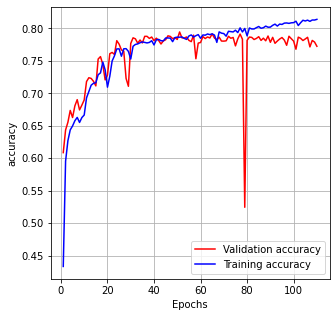

Test accuracy: 0.7630336880683899
Test loss: 0.9988327622413635


In [100]:
model_paras = model.history
x = list(range(1,len(model_paras.history['loss']) + 1))
plt.figure(figsize=(5,5))
plt.plot(x,model_paras.history['val_accuracy'],color = 'r',label = 'Validation accuracy')
plt.plot(x,model_paras.history['accuracy'],color = 'b',label = 'Training accuracy')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()
# Final evaluation of the model
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))
score, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

In [101]:
model.save('models/xmeas_1')

INFO:tensorflow:Assets written to: models/xmeas_1\assets


# Random Forest

In [26]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500],
     'max_depth':[15,20,25,30,35]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1_micro',cv=3)
model.fit(train_norm,y_train)
print("Best estimator is", model.best_params_)

NameError: name 'RandomForestClassifier' is not defined

# Confusion Matrix

In [27]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)

    
    B =(C/C.sum(axis=0))

    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(20,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(20,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  23.69662921348315
-------------------------------------------------- Confusion matrix --------------------------------------------------


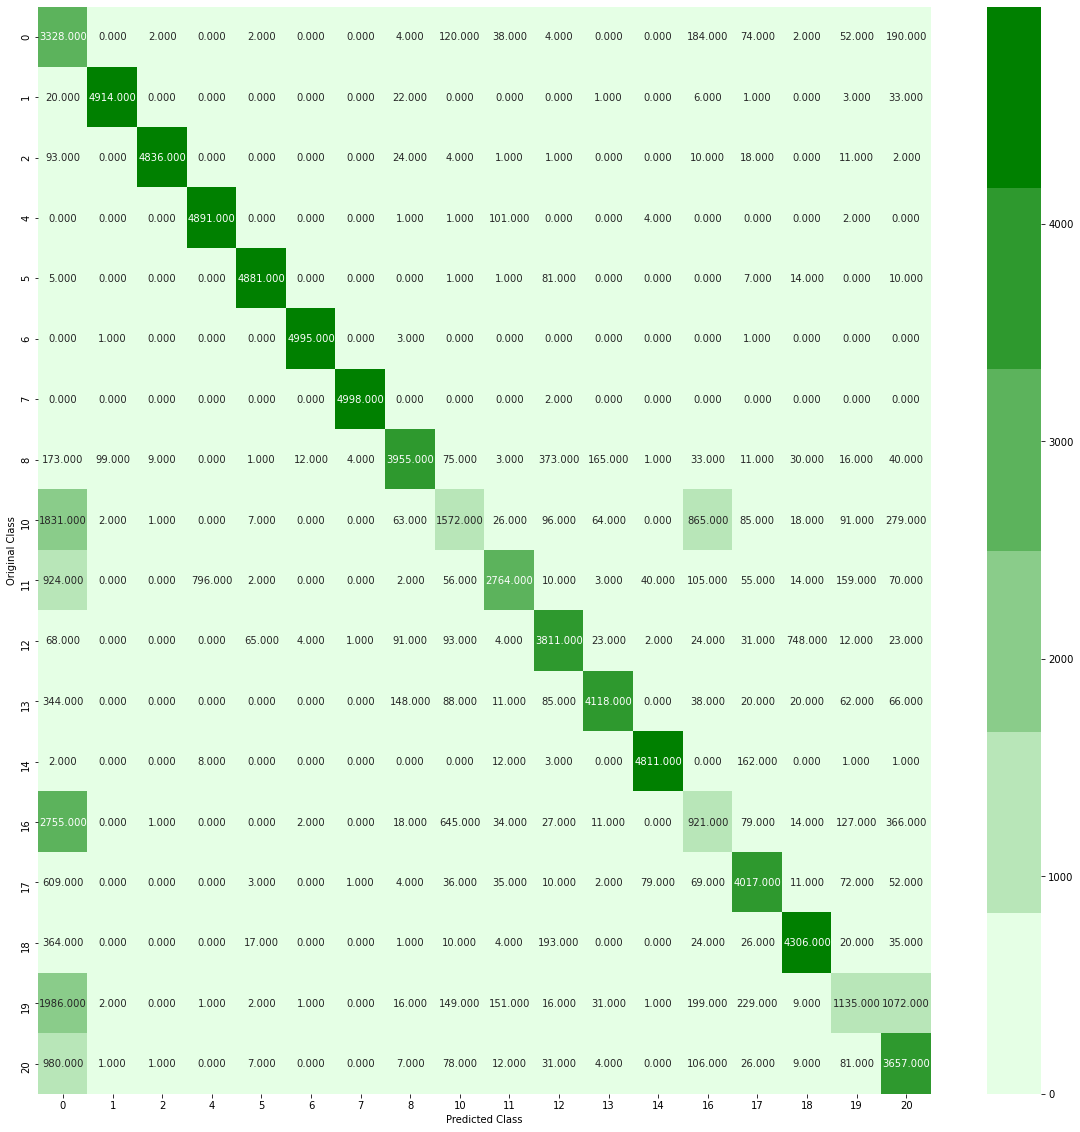

-------------------------------------------------- Precision matrix --------------------------------------------------


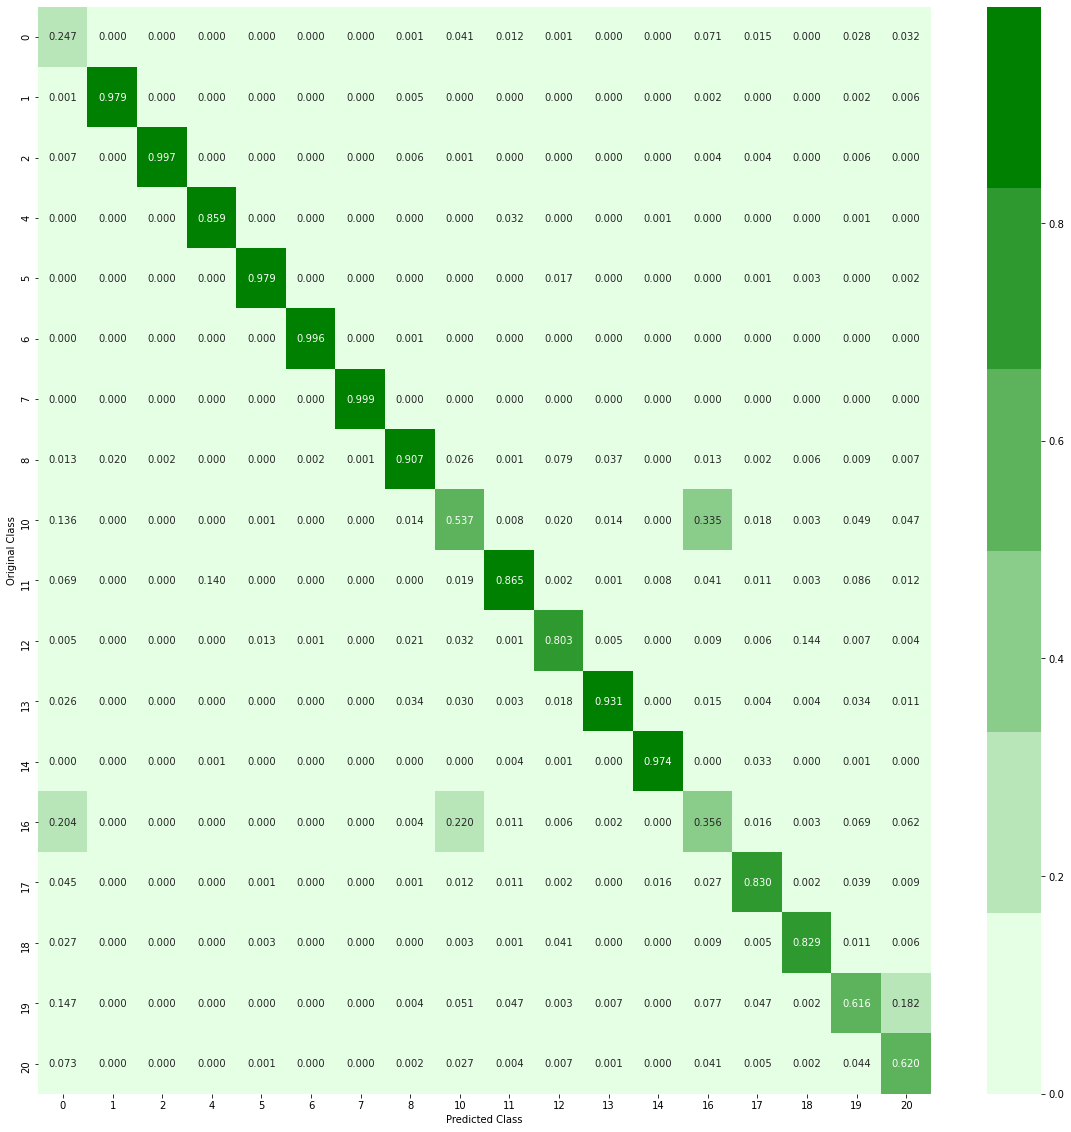

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


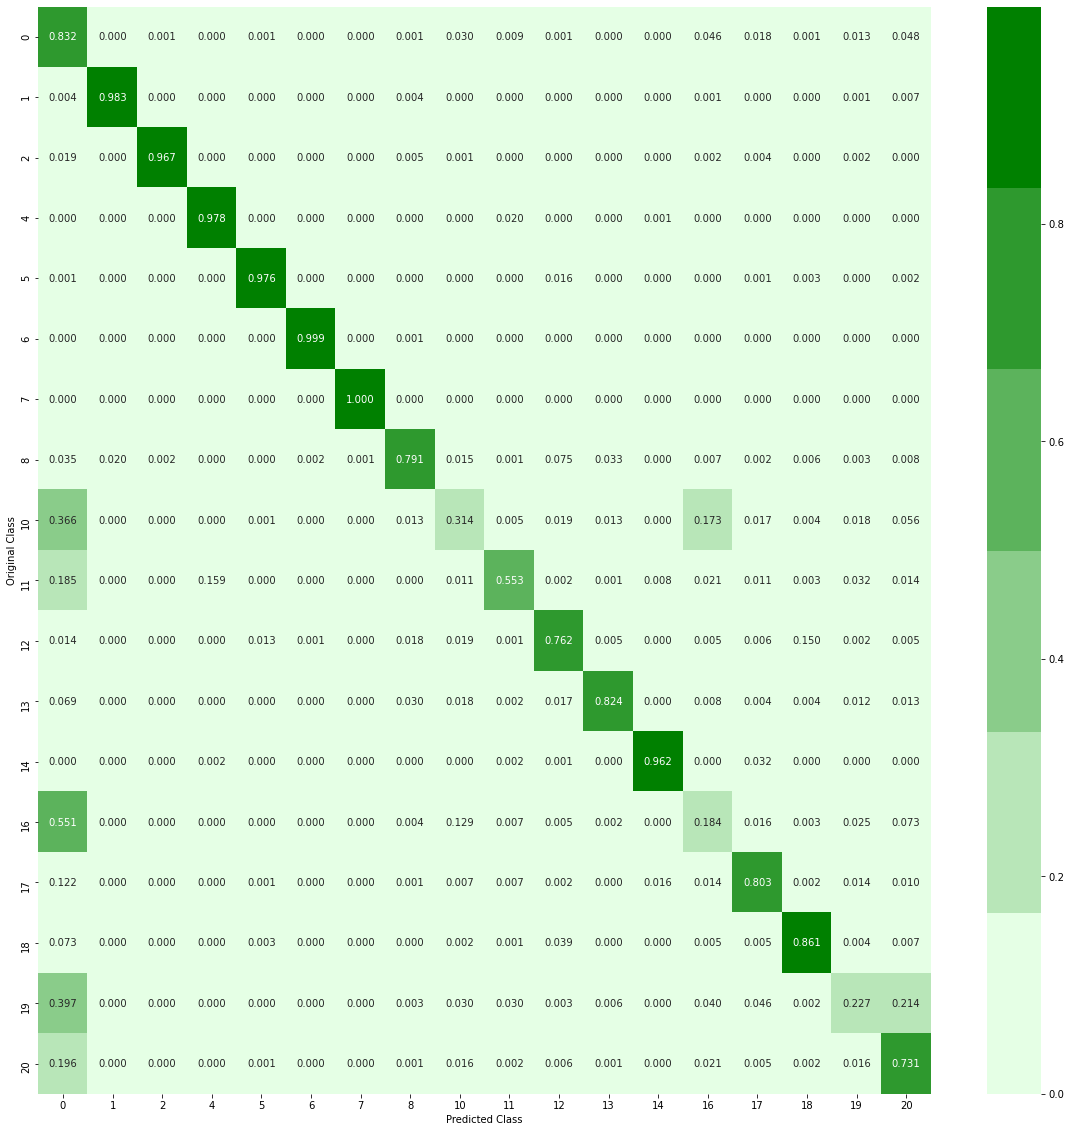

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [102]:
y = model.predict_proba(x_test)
plot_confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y,axis = 1))